## Spherical Splines based on Jupp & Kent (1987)

This notebook implements the algorithm for fitting splines introdiced in [Fitting Smooth Paths to Spherical Data](https://www.jstor.org/stable/2347843). The same implements a series of projections of spherical data to the 2D plane and then applies splines fit there. 

In [1]:
import pandas as pd
import numpy as np
import os
import cartopy.crs as ccrs
import pmagpy.ipmag as ipmag

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams["figure.figsize"] = (15, 20)

from utils.spherical_splines import *

In [2]:
%load_ext autoreload
%autoreload 2

As an example, we are going to use the same example the authors use in the paper. Something that is not clear is what to do with points with same age. Traditional splines methods don't allow to use more than one data point per same age/dependent variable. 

In [5]:
# example = 'real_poles'
# example = 'toy'
example = 'Torsvik2012'

if example == 'real_poles':

    df = pd.read_csv('data/df_pole_compilation_by_study.csv', encoding="cp1254")
    df['Time'] = df['mean_age']
    df['Lat'] = - df['Plat'] # reverse latitude to coincide with north pole following the defaul to Jupp
    df['Lon'] = df['Plon']
    df = df[['Time', "Lat", 'Lon']]


elif example == 'toy':  
    
    df = pd.read_csv('data/Jupp-etal-1987_dataset.csv', encoding="cp1254")

    # In order to do splines, we need the time coordinate to be strictly increasing. This is a little bit annoying, so for now
    # we replace poles with same age by picking the first one in the age
    df = df.groupby(['Time']).first().reset_index()
    #df['Time'] += np.random.normal(0, 0.001, df.shape[0])
    df['Lat'] = 90 - df['Time'] * 0.1
    df['Lon'] = df['Time'] * 0.5 

if example == 'Torsvik2012':
    df = pd.read_csv('data/Torsvik-etal-2012_dataset.csv', encoding="cp1254")
    print(np.unique(df.Plate))
    #WesternAustralia, East Antarctica, the Indian subcontinent, Madagascar,South America (Amazonia, Parana, Colorado and Patagonia), NWand NE Africa, Somalia, and Arabia.
    df = df[df.Plate.isin(['Amazonia', 'Parana', 'Colorado', 'Southern_Africa', 'East_Antarctica', 'Madagascar', 'Patagonia', 'Northeast_Africa'
 'Northwest_Africa', 'Somalia', 'Arabia'])]
    print(np.unique(df.Plate))
    df.RLat.fillna(df.Lat, inplace=True)
    df.RLon.fillna(df.Lon, inplace=True)
    df['Time'] = df['Age']
    df['Lat'] = - df['RLat'] # reverse latitude to coincide with north pole following the defaul to Jupp
    df['Lon'] = df['RLon']
    df = df.groupby(['Time']).first().reset_index()
    df = df[['Time', "Lat", 'Lon', 'Q']]
    
# Add cartesian coordinates
df['x'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
df['y'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
df['z'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

df = df.sort_values(by='Time')

df

['Amazonia' 'Arabia' 'Australia' 'Colorado' 'East_Antarctica'
 'East_Gondwana' 'Madagascar' 'Meseta' 'Northeast_Africa'
 'Northwest_Africa' 'Parana' 'Patagonia' 'Somalia' 'Southern_Africa'
 'europe' 'greenland' 'north_america']
['Amazonia' 'Arabia' 'Colorado' 'East_Antarctica' 'Madagascar' 'Parana'
 'Patagonia' 'Somalia' 'Southern_Africa']


,Time,Lat,Lon,Q,x,y,z
0,1.0,87.5,-2.3,3,0.043584,-0.001751,0.999048
1,2.0,87.3,34.3,3,0.038915,0.026546,0.998890
2,2.5,79.6,-11.0,3,0.177203,-0.034445,0.983571
3,5.0,85.7,30.7,5,0.064471,0.038280,0.997185
4,8.5,85.5,-37.4,3,0.062329,-0.047654,0.996917
...,...,...,...,...,...,...,...
85,510.0,-24.1,12.1,3,0.892554,0.191347,-0.408330
86,515.0,-9.5,6.1,3,0.980701,0.104807,-0.165048
87,521.0,-1.6,-10.7,4,0.982230,-0.185594,-0.027922
88,522.0,-27.8,-15.9,5,0.850738,-0.242339,-0.466387


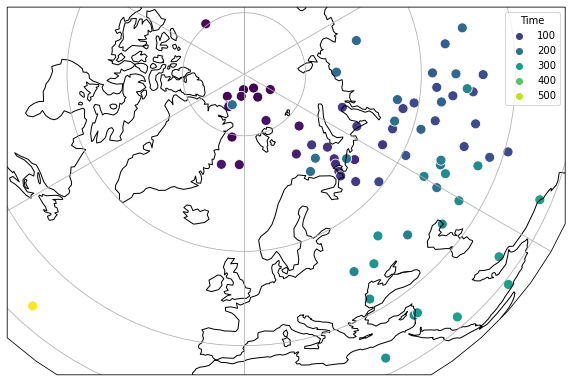

In [6]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

## Experiment

In [7]:
%%time

log_smoothings = np.linspace(-4, -1, 10)
smoothings = 10 ** log_smoothings
# smoothings = [0.0001]

all_curves = {}

for s in smoothings:
    
    print("Running smoothing = ", s)
    
    final_curve = spherical_spline(times=df.Time.values,
                                   knot_values=df[['x','y','z']].values,
                                   smoothing=s,
                                   precision=0.1,
                                   ode_stepsize=0.01,    # never pick less than 0.01
                                   n_iter=10,
                                   weights=df.Q.values,
                                   fix_origin=True)
    all_curves[s] = final_curve

Running smoothing =  0.0001
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.00021544346900318845
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.00046415888336127773
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.001
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.002154434690031882
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.004641588833612777
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.01
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.021544346900318822
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.046415888336127774
Maximul tolerance reached after a total of 10 iterations.
Running smoothing =  0.1
CPU times: user 21min 42s, sys: 454 ms, total: 21min 43s
Wall time: 21min 42s


Smooth:  0.00046415888336127773


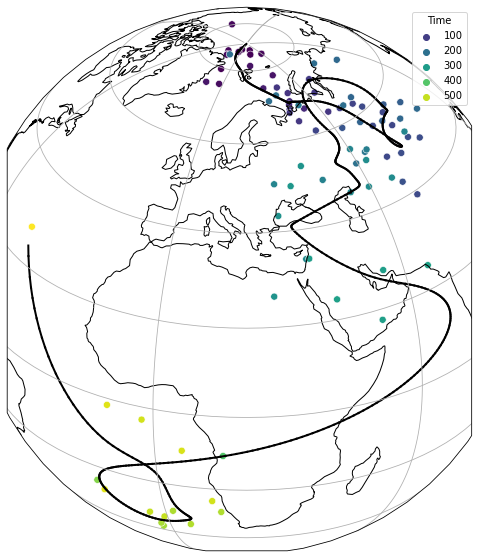

In [18]:
all_keys = list(all_curves.keys())
idx = 2
s = all_keys[idx]
print('Smooth: ', s)

curve = all_curves[s]

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=30, central_longitude=20))

ax.coastlines()
ax.gridlines()

# the first point is just noise... 
sph_splines = curve.knot_values[1:]

knot_values_sph = cart2sph(sph_splines, radians=False)[::10,:]

for i in range(knot_values_sph.shape[0]-1):
    plt.plot([knot_values_sph[i,0], knot_values_sph[i+1,0]], 
             [knot_values_sph[i,1], knot_values_sph[i+1,1]],
             linewidth=2, color='black',
             transform = ccrs.Geodetic())


sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=50,
                palette="viridis",
                transform = ccrs.PlateCarree());